In [1]:
import tensorflow as tf
from tensorflow.python.framework import graph_util
from tensorflow.python.framework import graph_io
from keras import backend as K
ksess = K.get_session()

C:\Users\gmlrn\Anaconda3\envs\IMR\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\gmlrn\Anaconda3\envs\IMR\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\gmlrn\Anaconda3\envs\IMR\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\gmlrn\Anaconda3\envs\IMR\lib\site-packages\tensorflow\python\framework

In [2]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# 과거 버전
print(librosa.__version__)

0.6.3


In [4]:
# 0.8.0
# !pip install librosa

In [11]:
import keras
from keras.layers import Dense, Conv2D, SeparableConv2D, Convolution2D, AveragePooling2D
from keras.layers import MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D, Activation, Dropout, BatchNormalization, Flatten, Input
from keras.models import Model, Sequential
from keras.applications.mobilenetv2 import MobileNetV2

In [12]:
base_model = MobileNetV2(weights=None, input_shape=(128, 128, 1), include_top=False,
                        alpha=0.35, depth_multiplier=0.5)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [13]:
model.load_weights('./mobilenetv2_youtube_5cls_44100.h5')

In [4]:
sampling_rate = 44100
duration = 1
samples = sampling_rate * duration 
n_mels = 128
hop_length = 347
n_fft = n_mels * 20
fmin = 20
fmax = sampling_rate // 2
dims = (128, 128, 1)

In [5]:
def read_audio(pathname, trim_long_data):
    y, sr = librosa.load(pathname, sr=sampling_rate)
    # trim silence
    if 0 < len(y): # workaround: 0 length causes error
        y, _ = librosa.effects.trim(y) # trim, top_db=default(60)
    # make it unified length to conf.samples
    if len(y) > samples: # long enough
        if trim_long_data:
            y = y[0:0+samples]
    else: # pad blank
        padding = samples - len(y)    # add padding at both ends
        offset = padding // 2
        y = np.pad(y, (offset, samples - len(y) - offset), 'constant')
    return y

In [6]:
def audio_to_melspectrogram(audio):
    spectrogram = librosa.feature.melspectrogram(audio,
                                                 sr=sampling_rate,
                                                 n_mels=n_mels,
                                                 hop_length=hop_length,
                                                 n_fft=n_fft,
                                                 fmin=fmin,
                                                 fmax=fmax)
    spectrogram = librosa.power_to_db(spectrogram)
    spectrogram = spectrogram.astype(np.float32)
    return spectrogram

In [7]:
def mels_len(mels):
    """Gets lenfth of log mel-spectrogram."""
    return mels.shape[1]

In [8]:
def samplewise_normalize_audio_X(X):
    for i in range(len(X)):
        X[i] -= np.min(X[i])
        X[i] /= (np.max(np.abs(X[i])) + 1.0)

In [9]:
def audio_sample_to_X(wave):
    mels = audio_to_melspectrogram(wave)
    X = []
    for s in range(0, mels_len(mels) // dims[1]):
        cur = s * dims[1]
        X.append(mels[:, cur:cur + dims[1]][..., np.newaxis])
    X = np.array(X)
    samplewise_normalize_audio_X(X)
    return X

In [10]:
def load_sample_as_X(filename, trim_long_data):
    wave = read_audio(filename, trim_long_data)
    return audio_sample_to_X(wave)

In [11]:
def show_melspectrogram(mels, title='Log-frequency power spectrogram'):
    import IPython
    import matplotlib
    from sklearn.model_selection import StratifiedKFold
    matplotlib.style.use('ggplot')

    librosa.display.specshow(mels, x_axis='time', y_axis='mel',
                             sr=sampling_rate, hop_length=hop_length,
                            fmin=fmin, fmax=fmax)
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.show()

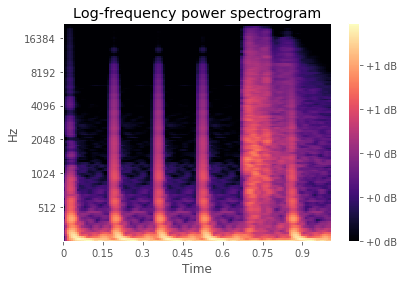

In [12]:
X = load_sample_as_X("./audio/2 Hearts.wav", False)
show_melspectrogram(X[0, ..., -1])

In [7]:
print(librosa.__version__)

0.6.3


In [13]:
import numba
print(numba.__version__)

0.48.0


In [13]:
import os

In [14]:
print(ksess)

In [15]:
K.set_learning_phase(0)
graph = ksess.graph
kgraph = graph.as_graph_def()
print(kgraph)

versions {
  producer: 26
}



In [16]:
# import os
# num_output = 1
# prefix = "output"
# pred = [None]*num_output
# outputName = [None]*num_output
# for i in range(num_output):
#     outputName[i] = prefix + str(i)
#     pred[i] = tf.identity(model.get_output_at(i), name=outputName[i])
# print('output name: ', outputName)

# # convert variables in the model graph to constants
# constant_graph = graph_util.convert_variables_to_constants(ksess, ksess.graph.as_graph_def(), outputName)

# # save the model in .pb and .txt
output_dir = "./"
output_graph_name = "mobilenetv2_youtube_5cls_44100.pb"
# output_text_name = "mobilenetv2_youtube_5cls_44100.txt"
# graph_io.write_graph(constant_graph, output_dir, output_graph_name, as_text=False)
# graph_io.write_graph(constant_graph, output_dir, output_text_name, as_text=True)
# print('saved graph .pb at: {0}\nsaved graph .txt at: {1}'.format(
#         os.path.join(output_dir, output_graph_name),
#         os.path.join(output_dir, output_text_name)))

In [17]:
def load_graph(model_file):
    graph = tf.Graph()
    graph_def = tf.GraphDef()

    with open(model_file, "rb") as f:
        graph_def.ParseFromString(f.read())
    with graph.as_default():
        tf.import_graph_def(graph_def)
    return graph

tfmodel = load_graph(os.path.join(output_dir, output_graph_name))

In [18]:
opers = tfmodel.get_operations()
names = [oper.name for oper in opers]
for name in names:
    if 0 <= name.find('keras') or 0 <= name.find('input') or 0 <= name.find('output'):
        print(name)

import/input_1
import/bn_Conv1/keras_learning_phase/input
import/bn_Conv1/keras_learning_phase
import/output0


In [14]:
tfmodel.get_operations()

[<tf.Operation 'import/input_1' type=Placeholder>,
 <tf.Operation 'import/Conv1/kernel' type=Const>,
 <tf.Operation 'import/Conv1/kernel/read' type=Identity>,
 <tf.Operation 'import/Conv1/convolution' type=Conv2D>,
 <tf.Operation 'import/bn_Conv1/gamma' type=Const>,
 <tf.Operation 'import/bn_Conv1/gamma/read' type=Identity>,
 <tf.Operation 'import/bn_Conv1/beta' type=Const>,
 <tf.Operation 'import/bn_Conv1/beta/read' type=Identity>,
 <tf.Operation 'import/bn_Conv1/moving_mean' type=Const>,
 <tf.Operation 'import/bn_Conv1/moving_mean/read' type=Identity>,
 <tf.Operation 'import/bn_Conv1/moving_variance' type=Const>,
 <tf.Operation 'import/bn_Conv1/moving_variance/read' type=Identity>,
 <tf.Operation 'import/bn_Conv1/batchnorm/add/y' type=Const>,
 <tf.Operation 'import/bn_Conv1/batchnorm/add' type=Add>,
 <tf.Operation 'import/bn_Conv1/batchnorm/Rsqrt' type=Rsqrt>,
 <tf.Operation 'import/bn_Conv1/batchnorm/mul' type=Mul>,
 <tf.Operation 'import/bn_Conv1/batchnorm/mul_1' type=Mul>,
 <tf.Op

In [19]:
inLayer = tfmodel.get_operation_by_name('import/input_1')
learnPhase = tfmodel.get_operation_by_name('import/bn_Conv1/keras_learning_phase')
outLayer = tfmodel.get_operation_by_name('import/output0')

In [20]:
mood_labels = ['어두움', '슬픔', '화남', '행복', '밝음']

In [21]:
preds_list = []

In [22]:
from collections import Counter 

In [56]:
with tf.Session(graph=tfmodel) as sess:
    tf_preds = sess.run(outLayer.outputs[0], 
                       {inLayer.outputs[0]: X,
                        learnPhase.outputs[0]: 0})
for pred in tf_preds:
    result = np.argmax(pred)
#     print(mood_labels[result], pred[result])
    preds_list.append(mood_labels[result])


어두운 0.9991721
어두운 0.6357871
어두운 0.88394177
어두운 0.48805407
어두운 0.8343944
어두운 0.9931859
어두운 0.79041475
어두운 0.45250976
어두운 0.99366015
어두운 0.9934278
어두운 0.4305835
어두운 0.4226197
어두운 0.4124236
어두운 0.96883094
밝음 0.4396866
어두운 0.6136047
어두운 0.9871797
어두운 0.9197322
어두운 0.64699554
어두운 0.9053745
어두운 0.9932954
어두운 0.974146
행복 0.29147395
어두운 0.55304635
어두운 0.99453
어두운 0.50447243
어두운 0.5582975
어두운 0.87711394
어두운 0.67771846
어두운 0.9933049
어두운 0.6815845
어두운 0.70073533
어두운 0.41116235
어두운 0.8587543
슬픔 0.43286502
슬픔 0.33678573
행복 0.9194922
행복 0.79699355
행복 0.46649092
행복 0.74351746
어두운 0.996801
슬픔 0.91901225
어두운 0.8131678
밝음 0.3269327
밝음 0.39788097
어두운 0.92075473
슬픔 0.9024385
어두운 0.69244474
어두운 0.93973315
어두운 0.8198453
밝음 0.5855502
어두운 0.8850933
어두운 0.9743526
화남 0.5710404
행복 0.9748165
어두운 0.9037299
어두운 0.8368723
어두운 0.63378936
어두운 0.97479445
화남 0.50495666
어두운 0.3307789
화남 0.4668406
행복 0.5727784
어두운 0.9936178
어두운 0.9935116
어두운 0.9599887
밝음 0.6670279
밝음 0.51465714
어두운 0.440248
행복 0.5213729
어두운 0.9202913
밝음 0

In [53]:
len(preds_list)

363

In [50]:
classifier = Counter(preds_list)
print(classifier.most_common(1)[0][0])

어두운


In [23]:
import pandas as pd

In [24]:
os.getcwd()

'C:\\Users\\gmlrn\\Desktop\\AI_SCHOOL\\기업 프로젝트\\youtube_audio_long'

In [27]:
df_train = pd.read_csv("../../input/freesound-audio-tagging/train_post_competition.csv")
df_train

,fname,label,manually_verified,freesound_id,license
0,00044347.wav,Hi-hat,0,28739,Attribution
1,001ca53d.wav,Saxophone,1,358827,Attribution
2,002d256b.wav,Trumpet,0,10897,Creative Commons 0
3,0033e230.wav,Glockenspiel,1,325017,Attribution
4,00353774.wav,Cello,1,195688,Attribution
5,003b91e8.wav,Cello,0,77944,Attribution
6,003da8e5.wav,Knock,1,164564,Creative Commons 0
7,0048fd00.wav,Gunshot_or_gunfire,1,274119,Creative Commons 0
8,004ad66f.wav,Clarinet,0,248370,Attribution
9,0063ab88.wav,Computer_keyboard,0,210304,Creative Commons 0


In [28]:
path = ["../../input/freesound-audio-tagging/audio_train/"+fname for fname in df_train.fname]

In [29]:
path

['../../input/freesound-audio-tagging/audio_train/00044347.wav',
 '../../input/freesound-audio-tagging/audio_train/001ca53d.wav',
 '../../input/freesound-audio-tagging/audio_train/002d256b.wav',
 '../../input/freesound-audio-tagging/audio_train/0033e230.wav',
 '../../input/freesound-audio-tagging/audio_train/00353774.wav',
 '../../input/freesound-audio-tagging/audio_train/003b91e8.wav',
 '../../input/freesound-audio-tagging/audio_train/003da8e5.wav',
 '../../input/freesound-audio-tagging/audio_train/0048fd00.wav',
 '../../input/freesound-audio-tagging/audio_train/004ad66f.wav',
 '../../input/freesound-audio-tagging/audio_train/0063ab88.wav',
 '../../input/freesound-audio-tagging/audio_train/006f2f32.wav',
 '../../input/freesound-audio-tagging/audio_train/0075d39c.wav',
 '../../input/freesound-audio-tagging/audio_train/00780200.wav',
 '../../input/freesound-audio-tagging/audio_train/0079d310.wav',
 '../../input/freesound-audio-tagging/audio_train/0091fc7f.wav',
 '../../input/freesound-a

In [41]:
mood_dict = {}

In [42]:
for fname in path:
    preds_list = []
    
    X = load_sample_as_X(fname, False)
    with tf.Session(graph=tfmodel) as sess:
        tf_preds = sess.run(outLayer.outputs[0], 
                       {inLayer.outputs[0]: X,
                        learnPhase.outputs[0]: 0})
    for pred in tf_preds:
        result = np.argmax(pred)
        preds_list.append(mood_labels[result])
    
    classifier = Counter(preds_list)
    org = fname.split("../../input/freesound-audio-tagging/audio_train/")[1]
    val = classifier.most_common(1)[0][0]
    print(org, val)
    mood_dict[org] = val


00044347.wav 슬픔
001ca53d.wav 밝음
002d256b.wav 어두움
0033e230.wav 어두움
00353774.wav 슬픔
003b91e8.wav 밝음
003da8e5.wav 어두움
0048fd00.wav 어두움
004ad66f.wav 어두움
0063ab88.wav 어두움
006f2f32.wav 행복
0075d39c.wav 어두움
00780200.wav 화남
0079d310.wav 화남
0091fc7f.wav 어두움
0097160c.wav 어두움
00ad7068.wav 어두움
00c5808a.wav 어두움
00c82919.wav 화남
00c934d7.wav 화남
00c9e799.wav 화남
00cb787c.wav 슬픔
00ce569f.wav 화남
00d1fe46.wav 어두움
00d3bba3.wav 어두움
00d40fa2.wav 화남
00d9fa61.wav 어두움
00e2b4cd.wav 어두움
00f88dc5.wav 슬픔
00fbb28b.wav 밝음
00fcbab2.wav 어두움
010aa387.wav 화남
011a2185.wav 슬픔
0120d246.wav 어두움
01235a12.wav 어두움
01257aad.wav 화남
01302128.wav 행복
013264d3.wav 슬픔
013c3135.wav 슬픔
01506d76.wav 화남
015cf474.wav 어두움
0160d55e.wav 밝음
01638f61.wav 행복
0172a2a5.wav 어두움
017ea24e.wav 화남
01811e48.wav 행복
0184c390.wav 슬픔
018863f5.wav 밝음
018a10bb.wav 밝음
018b1df6.wav 화남
018d1dc4.wav 밝음
0193042e.wav 어두움
01974c7c.wav 행복
019aae9d.wav 화남
019d2a2c.wav 화남
01a36643.wav 화남
01a39e95.wav 화남
01a59a61.wav 슬픔
01a59c11.wav 슬픔
01a5dc85.wav 행복
01b9f44a.wav 어두움
01

0e7f9fdb.wav 어두움
0e89fb66.wav 밝음
0e974517.wav 밝음
0e979b8c.wav 어두움
0e9cb14e.wav 밝음
0ea3dbaf.wav 슬픔
0eb63f5a.wav 밝음
0ec012fc.wav 행복
0ecb56ad.wav 밝음
0ed06544.wav 밝음
0ede064f.wav 행복
0ee42262.wav 슬픔
0eeaebcb.wav 어두움
0ef9a602.wav 행복
0f01e836.wav 화남
0f18c55b.wav 어두움
0f1a5928.wav 행복
0f1dbff5.wav 행복
0f23d7e4.wav 화남
0f274e7a.wav 행복
0f2903db.wav 어두움
0f2ab678.wav 밝음
0f34d08e.wav 행복
0f36e49a.wav 어두움
0f444884.wav 어두움
0f5286d1.wav 어두움
0f53ac39.wav 밝음
0f5c62dd.wav 슬픔
0f6e2a63.wav 화남
0f70f92f.wav 행복
0f72651c.wav 화남
0f7f0d86.wav 화남
0f936928.wav 행복
0f958ff0.wav 슬픔
0f96c40d.wav 화남
0fa3ee45.wav 밝음
0fa61324.wav 밝음
0fafb777.wav 어두움
0fb0c2e1.wav 밝음
0fb464cf.wav 화남
0fc39673.wav 행복
0fcdc341.wav 어두움
0fd52405.wav 어두움
0fe6c47d.wav 행복
0ff26813.wav 행복
0ff3a423.wav 행복
0ff4262d.wav 밝음
0ff6fdf5.wav 밝음
0ffff94f.wav 행복
100009e2.wav 화남
10086933.wav 밝음
10099e50.wav 슬픔
100f6b3f.wav 어두움
1023facf.wav 어두움
102db6b4.wav 슬픔
102ef2c7.wav 어두움
1032e684.wav 슬픔
10357e1e.wav 슬픔
103b9ed4.wav 슬픔
103dfb7c.wav 어두움
103eceae.wav 화남
103f29e5.

1bc55c17.wav 밝음
1bc8eae1.wav 행복
1bcb3c6f.wav 밝음
1bcf0664.wav 밝음
1bd3ba0b.wav 어두움
1bda949f.wav 어두움
1bdc4940.wav 어두움
1bec87d9.wav 화남
1bf70cc6.wav 행복
1bf859a7.wav 밝음
1c0d5682.wav 밝음
1c133d0e.wav 화남
1c189121.wav 행복
1c2b5b18.wav 어두움
1c3b4067.wav 화남
1c3b61c8.wav 어두움
1c3d00bf.wav 어두움
1c3e1a54.wav 어두움
1c3ed083.wav 행복
1c4c0a51.wav 밝음
1c4d9c4c.wav 행복
1c520cae.wav 어두움
1c590c46.wav 슬픔
1c603b9f.wav 어두움
1c67a5b9.wav 행복
1c6b07b8.wav 밝음
1c720526.wav 어두움
1c76a229.wav 행복
1c78595a.wav 행복
1c8943c0.wav 어두움
1c8cddc2.wav 행복
1c9a423f.wav 어두움
1ca0bd2f.wav 밝음
1ca4d107.wav 어두움
1cc13604.wav 화남
1cc55db4.wav 어두움
1cccb873.wav 밝음
1cd6919e.wav 어두움
1ce38807.wav 슬픔
1ce4a00e.wav 밝음
1ce70b78.wav 행복
1ced478c.wav 슬픔
1cf3ee46.wav 어두움
1d08bd6d.wav 화남
1d0c860b.wav 슬픔
1d119cfc.wav 어두움
1d1d0d72.wav 밝음
1d23c74b.wav 슬픔
1d23fb6d.wav 슬픔
1d24518b.wav 슬픔
1d26c5e5.wav 어두움
1d2808dd.wav 어두움
1d28b9cb.wav 행복
1d395faa.wav 행복
1d3a05ab.wav 어두움
1d491960.wav 밝음
1d542616.wav 어두움
1d5a6f5f.wav 슬픔
1d5d63d1.wav 어두움
1d73907a.wav 화남
1d8502f5.wav 어두움
1

2939852d.wav 행복
29441746.wav 행복
2953359d.wav 어두움
2968fbcd.wav 밝음
2979f92a.wav 슬픔
297e7f77.wav 행복
2987ab41.wav 어두움
299ad29c.wav 어두움
29a016e0.wav 밝음
29a57707.wav 밝음
29a96a60.wav 밝음
29b51ca2.wav 어두움
29c8132a.wav 화남
29c9e829.wav 어두움
29d2bf8b.wav 행복
29d5108a.wav 밝음
29dcc9de.wav 화남
29de4510.wav 화남
29e0a702.wav 어두움
29ea06f9.wav 화남
29ea2c57.wav 슬픔
29f2ff7d.wav 행복
29ff7d7b.wav 어두움
2a069951.wav 행복
2a1540b1.wav 어두움
2a180be4.wav 화남
2a3087ed.wav 행복
2a3b0b61.wav 슬픔
2a4aa95d.wav 어두움
2a4d4883.wav 어두움
2a55208f.wav 슬픔
2a559a5d.wav 화남
2a5dd0de.wav 슬픔
2a682d6b.wav 행복
2a72b20b.wav 어두움
2a756789.wav 밝음
2a85260b.wav 밝음
2a871432.wav 행복
2a8f8f85.wav 어두움
2a905697.wav 화남
2a933c1e.wav 밝음
2a9c3044.wav 화남
2aa94643.wav 어두움
2aac13ec.wav 밝음
2aad886a.wav 행복
2aafe190.wav 행복
2ab81fda.wav 행복
2ac8b94f.wav 슬픔
2accbe0b.wav 슬픔
2ad59d34.wav 어두움
2ae249e8.wav 슬픔
2ae34e2b.wav 화남
2af48f93.wav 어두움
2af5172d.wav 슬픔
2af5749f.wav 슬픔
2afcc575.wav 행복
2b0c0c90.wav 어두움
2b13754b.wav 어두움
2b16db4d.wav 화남
2b188948.wav 밝음
2b1ed909.wav 밝음
2b2e2b8

37bffa64.wav 화남
37c85fee.wav 밝음
37cebbd4.wav 어두움
37d0eec4.wav 행복
37d0eed3.wav 어두움
37d26e27.wav 슬픔
37d5d788.wav 어두움
37ddee5e.wav 어두움
37e13c23.wav 행복
37e5557d.wav 행복
37eb63b4.wav 밝음
37f5403f.wav 행복
37fb0c92.wav 화남
380048b8.wav 행복
38042954.wav 슬픔
38045adb.wav 어두움
3804ed01.wav 어두움
380ca85c.wav 밝음
3811852f.wav 어두움
3814ab19.wav 화남
381c8f4f.wav 슬픔
38216fad.wav 밝음
3824a5f6.wav 어두움
38311105.wav 어두움
3835cfbd.wav 행복
383d6533.wav 어두움
383de66f.wav 화남
38460d69.wav 밝음
3846f2fa.wav 화남
384712f0.wav 어두움
384e198d.wav 어두움
384f43cf.wav 슬픔
385c2814.wav 밝음
385e9493.wav 어두움
386b8fc7.wav 어두움
3874b7b5.wav 행복
388093aa.wav 화남
388205af.wav 어두움
3882165a.wav 어두움
38852ae1.wav 화남
38883816.wav 어두움
388d1301.wav 어두움
389ef6d7.wav 어두움
38b1ac4e.wav 어두움
38bc302a.wav 밝음
38cb633d.wav 어두움
38cee215.wav 슬픔
38d2e014.wav 화남
38d30516.wav 화남
38e16501.wav 행복
38e1a81c.wav 어두움
38ec4038.wav 화남
38ee5f4c.wav 어두움
38f3f2c6.wav 어두움
38f5a8df.wav 행복
38f63d36.wav 어두움
38fddec0.wav 밝음
39000328.wav 행복
390292b8.wav 행복
390de47b.wav 슬픔
39193622.wav 밝음

450762c4.wav 밝음
4509d8c8.wav 어두움
450b7adb.wav 밝음
450cd355.wav 어두움
45175cc0.wav 밝음
4517a4af.wav 어두움
45243c3d.wav 슬픔
45250e90.wav 슬픔
4526e386.wav 밝음
452a9812.wav 밝음
4541aa66.wav 어두움
45449f84.wav 어두움
4546e002.wav 행복
4549ffaf.wav 어두움
4551f231.wav 어두움
455377bf.wav 행복
45539540.wav 어두움
45539bb8.wav 화남
455aee34.wav 어두움
45665f2e.wav 행복
456cc727.wav 어두움
458b1992.wav 밝음
458ea6cc.wav 밝음
4590ba37.wav 화남
45910ae0.wav 어두움
45a8823e.wav 어두움
45a8d396.wav 행복
45b9bc91.wav 밝음
45bf81f1.wav 어두움
45c077da.wav 화남
45ce1b24.wav 밝음
45d405ca.wav 슬픔
45d71502.wav 어두움
45da8553.wav 어두움
45de3233.wav 행복
45e241c1.wav 슬픔
45e5a952.wav 슬픔
45e63fdd.wav 밝음
45e6e129.wav 행복
45ea531e.wav 화남
45f3e225.wav 화남
4601c0f2.wav 행복
46076458.wav 행복
460d7b62.wav 화남
461558c3.wav 밝음
4619c0dd.wav 어두움
461c6cd1.wav 화남
4629e77b.wav 어두움
462b676f.wav 행복
4636fd73.wav 행복
464c651e.wav 어두움
465cf6eb.wav 어두움
46657625.wav 화남
46670055.wav 행복
466a45d5.wav 어두움
46732e56.wav 행복
46768bc1.wav 어두움
46772c0d.wav 어두움
467953c6.wav 밝음
46798d97.wav 어두움
467ad774.wav 행복
4

518ea0eb.wav 어두움
51994034.wav 화남
519b068d.wav 어두움
51a0ed08.wav 밝음
51a51d9d.wav 밝음
51afebdf.wav 어두움
51b14c9d.wav 행복
51b9d0b7.wav 화남
51bc618d.wav 화남
51c4cd41.wav 행복
51cbcf35.wav 슬픔
51cfc1d3.wav 어두움
51d28a24.wav 밝음
51edf8ee.wav 밝음
51f845a4.wav 화남
51f9a488.wav 슬픔
51fc52e6.wav 화남
51ffc008.wav 어두움
5202c954.wav 밝음
5206fbc7.wav 슬픔
520b22f7.wav 화남
52127914.wav 밝음
5213c673.wav 화남
521c3585.wav 행복
52300f9b.wav 어두움
5230e439.wav 화남
5233fe9c.wav 행복
5237eea9.wav 행복
5239016a.wav 어두움
523f65d5.wav 슬픔
52422d3d.wav 어두움
52480f3e.wav 어두움
524dea8d.wav 어두움
5252f89f.wav 행복
5263369a.wav 어두움
52719891.wav 슬픔
527a6550.wav 행복
52834f79.wav 행복
5283a183.wav 행복
52860d22.wav 행복
5287b30b.wav 어두움
528b1fdc.wav 밝음
528fd885.wav 어두움
529c6ded.wav 화남
529ca3b3.wav 화남
52aceab1.wav 어두움
52b0d05c.wav 행복
52b61c21.wav 어두움
52ba1c68.wav 화남
52d30eec.wav 행복
52d78e42.wav 어두움
52e54bdd.wav 슬픔
52e5b888.wav 화남
52e8444c.wav 화남
52ef7355.wav 행복
52efdfdd.wav 어두움
5305bd4e.wav 어두움
530ff8db.wav 밝음
53157a1b.wav 슬픔
5315d52b.wav 행복
5316ab94.wav 행복
5318e9

5ec9e1e8.wav 어두움
5ed0b693.wav 행복
5ee394ce.wav 어두움
5eec8fe1.wav 어두움
5ef1bff4.wav 화남
5f011d45.wav 밝음
5f0dc8e4.wav 슬픔
5f11882f.wav 어두움
5f18dad3.wav 밝음
5f1fadee.wav 행복
5f20684f.wav 어두움
5f3186c8.wav 어두움
5f383659.wav 어두움
5f3f655e.wav 행복
5f4ede60.wav 화남
5f597196.wav 슬픔
5f59933f.wav 밝음
5f63bbad.wav 어두움
5f673482.wav 행복
5f6e7a2f.wav 행복
5f71ebaa.wav 어두움
5f73d3c8.wav 어두움
5f75b9cf.wav 행복
5f7d4d21.wav 밝음
5f7dd0fb.wav 밝음
5f886a73.wav 어두움
5f88f48e.wav 어두움
5f934315.wav 어두움
5f95ce73.wav 행복
5fa41f28.wav 행복
5fb10f46.wav 어두움
5fc120cc.wav 어두움
5fc54ba5.wav 밝음
5fca447b.wav 어두움
5fca79da.wav 어두움
5fcfe4c2.wav 어두움
5fd95b59.wav 행복
5fe07b4b.wav 밝음
5fe4741a.wav 행복
5fed8602.wav 행복
5ff4377d.wav 슬픔
600dc6d1.wav 행복
600fbad3.wav 밝음
600fe305.wav 화남
601c44d5.wav 어두움
602ca70a.wav 화남
602f68bf.wav 화남
6032d510.wav 슬픔
603cc6cd.wav 어두움
604b54a9.wav 밝음
604e28b1.wav 밝음
604f23cd.wav 행복
60531e43.wav 밝음
60541059.wav 행복
6064aad0.wav 화남
60691995.wav 밝음
6085c41b.wav 어두움
608ac00c.wav 슬픔
609e2253.wav 화남
60ac28c4.wav 어두움
60c03b3e.wav 밝음
60

6c923faa.wav 화남
6c9269c5.wav 화남
6c94cf13.wav 행복
6c98c870.wav 슬픔
6ca5f5d1.wav 행복
6cb35c9d.wav 행복
6cbb47e9.wav 어두움
6cbf3518.wav 밝음
6ccdd42c.wav 어두움
6ccf7c29.wav 밝음
6cd42ef4.wav 행복
6cde1300.wav 어두움
6ce42228.wav 어두움
6ce430d2.wav 밝음
6ce9cbde.wav 어두움
6ceab67a.wav 행복
6cf01b03.wav 화남
6cfd79c3.wav 어두움
6d01bc2c.wav 밝음
6d10d700.wav 화남
6d15afe2.wav 어두움
6d1e1e67.wav 어두움
6d21ad67.wav 행복
6d36591b.wav 슬픔
6d36f4e4.wav 밝음
6d3722db.wav 화남
6d3e8659.wav 행복
6d4be757.wav 행복
6d4fca1c.wav 어두움
6d52f8c1.wav 어두움
6d5abee4.wav 어두움
6d717c18.wav 행복
6d7b7a40.wav 밝음
6d8620e6.wav 밝음
6d9019ba.wav 어두움
6d9b63eb.wav 슬픔
6d9e7052.wav 어두움
6da3d596.wav 행복
6daab86c.wav 슬픔
6dc4e733.wav 화남
6dc525e7.wav 어두움
6dc89ee7.wav 어두움
6dcdddab.wav 밝음
6dd8c59b.wav 행복
6ddfdcfd.wav 어두움
6de38680.wav 슬픔
6de58fec.wav 어두움
6dea9b11.wav 밝음
6df2f14c.wav 어두움
6df575aa.wav 밝음
6dfd9bac.wav 어두움
6dfdf381.wav 슬픔
6e028fd5.wav 화남
6e09d1f2.wav 행복
6e139908.wav 화남
6e14925e.wav 슬픔
6e18d7ed.wav 화남
6e1f6a82.wav 슬픔
6e5088de.wav 화남
6e54b3a9.wav 슬픔
6e595f4e.wav 슬픔
6e787

7aba7444.wav 밝음
7abd44d6.wav 행복
7abd83be.wav 행복
7abe054d.wav 화남
7abf4794.wav 화남
7ac74e67.wav 어두움
7ac9a9bf.wav 어두움
7ad126fa.wav 어두움
7ad6dfec.wav 어두움
7ad8b447.wav 밝음
7ae6096a.wav 어두움
7ae92624.wav 어두움
7aeaa660.wav 행복
7aecd8c9.wav 밝음
7af0f234.wav 슬픔
7af76555.wav 슬픔
7afbf017.wav 행복
7b031e22.wav 밝음
7b07c16f.wav 밝음
7b085710.wav 슬픔
7b1650a0.wav 행복
7b27bd7b.wav 행복
7b2d02d4.wav 밝음
7b3bc373.wav 어두움
7b460e46.wav 밝음
7b4d4b59.wav 어두움
7b4d753c.wav 밝음
7b4e4ea4.wav 어두움
7b56ddc7.wav 화남
7b5777f2.wav 밝음
7b631ab5.wav 화남
7b6a119e.wav 슬픔
7b6b328f.wav 밝음
7b6f0648.wav 어두움
7b6f44ff.wav 어두움
7b766793.wav 행복
7b780fa4.wav 화남
7b859d4e.wav 밝음
7b8874c3.wav 행복
7b8e73b7.wav 화남
7b9a02a0.wav 밝음
7ba1bf05.wav 화남
7ba42f03.wav 어두움
7ba87647.wav 밝음
7baee018.wav 화남
7baf18f6.wav 밝음
7bb189e3.wav 어두움
7bb60688.wav 화남
7bbc5503.wav 밝음
7bc4dab0.wav 슬픔
7bc9c37f.wav 밝음
7bce7d7c.wav 행복
7bd01506.wav 어두움
7bfed231.wav 슬픔
7c07d6ac.wav 슬픔
7c07d9a2.wav 행복
7c097caf.wav 어두움
7c1cccaa.wav 화남
7c230e88.wav 행복
7c2ba8c5.wav 어두움
7c335009.wav 행복
7c3f7dda

88482f9c.wav 행복
88500b88.wav 슬픔
88507406.wav 어두움
8855b468.wav 밝음
8861d942.wav 행복
8863113b.wav 화남
8865cc0e.wav 어두움
886f3b89.wav 어두움
887435e1.wav 화남
88780eac.wav 행복
88811cbe.wav 행복
888cff5e.wav 어두움
88928a07.wav 어두움
889a0bc2.wav 밝음
889edf2f.wav 밝음
88ac1360.wav 슬픔
88c42e27.wav 어두움
88cb5fa7.wav 화남
88dbcd44.wav 밝음
88e24910.wav 행복
88e792b8.wav 어두움
88e99f1c.wav 화남
88f4eb4d.wav 행복
88fd411f.wav 행복
89055011.wav 어두움
8916ffcd.wav 슬픔
892505e9.wav 밝음
89269203.wav 어두움
8928d1c6.wav 화남
892a2db5.wav 슬픔
893427c3.wav 행복
893af25d.wav 어두움
89462d3b.wav 화남
894fd536.wav 화남
89515baf.wav 밝음
8952eee3.wav 화남
896797e3.wav 행복
897eed84.wav 어두움
897fc1c4.wav 밝음
8986cced.wav 어두움
8987511f.wav 슬픔
898a757e.wav 밝음
899e2e78.wav 어두움
899eb17b.wav 화남
89a058e2.wav 밝음
89a645fe.wav 화남
89adfd2e.wav 행복
89affc19.wav 어두움
89b17560.wav 밝음
89c2111f.wav 슬픔
89c5c01b.wav 밝음
89d12569.wav 슬픔
89d16dbb.wav 행복
89d4119c.wav 행복
89da251b.wav 행복
89e2578a.wav 화남
89e543b0.wav 화남
89f13bb9.wav 어두움
89f33989.wav 행복
89f8b625.wav 어두움
8a05af88.wav 어두움
8a11b73

96d2ea0b.wav 화남
96d2f638.wav 밝음
96dad435.wav 슬픔
96dc5309.wav 어두움
96df59a4.wav 어두움
96e3d136.wav 행복
96e5f7c8.wav 행복
96e65c33.wav 행복
96e9e3e9.wav 어두움
96eccbcd.wav 밝음
96f5ac69.wav 화남
96f9fc95.wav 어두움
97069127.wav 밝음
9713a607.wav 행복
97223bf2.wav 밝음
972527c2.wav 밝음
9728b75b.wav 슬픔
972a4b10.wav 화남
972b92c7.wav 어두움
973bef4c.wav 어두움
9742cc48.wav 화남
974e742a.wav 어두움
97599450.wav 행복
975fe58b.wav 화남
9760d7b1.wav 행복
976bb2f4.wav 밝음
976ebccb.wav 화남
977b44f9.wav 어두움
977cf8c5.wav 행복
978e0a19.wav 화남
9797e752.wav 화남
979b3c65.wav 밝음
97a079d5.wav 밝음
97a1d2cb.wav 슬픔
97abaf0c.wav 화남
97b26273.wav 어두움
97bbab94.wav 행복
97c1f8fe.wav 행복
97c2fed9.wav 슬픔
97d60ed0.wav 행복
97db1f95.wav 슬픔
97fa44da.wav 행복
9814c7c8.wav 행복
98155566.wav 화남
981567ee.wav 어두움
98251d65.wav 행복
982e16a5.wav 화남
982ef140.wav 행복
98333c50.wav 행복
9836ea79.wav 행복
9840f8a8.wav 어두움
98541a04.wav 어두움
9863b59b.wav 밝음
986817e9.wav 슬픔
9872bf34.wav 어두움
98744c9c.wav 화남
988025aa.wav 행복
9883561e.wav 어두움
9883aefa.wav 행복
98a1a3cb.wav 행복
98a3319e.wav 행복
98ad6653.w

a4c6a3f7.wav 행복
a4cf4827.wav 행복
a4d11070.wav 슬픔
a4da36e1.wav 어두움
a4e098cf.wav 슬픔
a4e1fac1.wav 밝음
a4f2be4f.wav 화남
a4f46324.wav 화남
a508c78f.wav 행복
a50b86f7.wav 화남
a50be6d7.wav 어두움
a50e8a8c.wav 어두움
a5157cb6.wav 밝음
a5173aa7.wav 화남
a52be763.wav 어두움
a531c210.wav 밝음
a53ed8df.wav 화남
a54169b3.wav 슬픔
a5447a9a.wav 화남
a549f01b.wav 행복
a56c5e8e.wav 슬픔
a5736387.wav 행복
a57ebb7c.wav 어두움
a57fa62a.wav 어두움
a58458cd.wav 밝음
a589dc29.wav 행복
a591054c.wav 어두움
a59b5a08.wav 슬픔
a59d8fcf.wav 행복
a5a1cee2.wav 화남
a5a68a8c.wav 어두움
a5a7b9a9.wav 화남
a5a7f4df.wav 어두움
a5b01a7d.wav 행복
a5b893e6.wav 어두움
a5bbd485.wav 화남
a5bfcdee.wav 어두움
a5c51c97.wav 어두움
a5c78dd5.wav 화남
a5c92b8f.wav 밝음
a5ca9e77.wav 어두움
a5d8d2fc.wav 행복
a5e5afb0.wav 슬픔
a5f2e58b.wav 화남
a5f57993.wav 행복
a5f5dbd7.wav 어두움
a5f8d853.wav 어두움
a603a2be.wav 어두움
a6066192.wav 행복
a60a1df6.wav 어두움
a611d977.wav 어두움
a614fce9.wav 어두움
a623039e.wav 어두움
a624984d.wav 어두움
a629ead0.wav 화남
a62aa4a5.wav 슬픔
a62eee5d.wav 행복
a63010f7.wav 어두움
a6339fc0.wav 밝음
a635795a.wav 밝음
a6420b34.wav 행복
a6

b342cc2f.wav 행복
b3451158.wav 밝음
b3485cc1.wav 슬픔
b34a9fd6.wav 화남
b3588e40.wav 어두움
b35ac4ef.wav 행복
b35b2952.wav 어두움
b35ec39e.wav 어두움
b36ddd2a.wav 행복
b37b60fb.wav 밝음
b38409bb.wav 행복
b386cc78.wav 행복
b389c99c.wav 어두움
b38ca397.wav 화남
b3935201.wav 행복
b393db3a.wav 밝음
b395e56b.wav 화남
b39db282.wav 밝음
b39e7571.wav 어두움
b3a24d4b.wav 행복
b3ac05e6.wav 행복
b3ad87ce.wav 행복
b3b542e9.wav 밝음
b3b77047.wav 밝음
b3bd7893.wav 행복
b3c8c704.wav 화남
b3ce4edb.wav 어두움
b3cee50d.wav 슬픔
b3d33a56.wav 어두움
b3d61327.wav 어두움
b3db6690.wav 어두움
b3e0f671.wav 밝음
b3e9fccb.wav 행복
b3f6f5ed.wav 어두움
b3f75e89.wav 어두움
b3fd8174.wav 밝음
b4014985.wav 어두움
b4029ee8.wav 행복
b4087165.wav 화남
b414cca6.wav 밝음
b41a30cc.wav 슬픔
b41d03ad.wav 행복
b4200d90.wav 밝음
b428466c.wav 행복
b42915bc.wav 슬픔
b430afb3.wav 화남
b4324916.wav 행복
b45ebbb1.wav 어두움
b4608f87.wav 화남
b462999a.wav 어두움
b469f417.wav 밝음
b46cb6aa.wav 밝음
b47d9321.wav 어두움
b47e0c27.wav 행복
b4815be4.wav 화남
b48d7f15.wav 슬픔
b490247e.wav 슬픔
b49f1430.wav 슬픔
b4a519aa.wav 슬픔
b4aa81ca.wav 행복
b4b2b68d.wav 밝음
b4b91963.

c015af58.wav 어두움
c015db25.wav 화남
c017f3f7.wav 행복
c01e53f9.wav 행복
c01ea334.wav 화남
c0236eea.wav 밝음
c02503c7.wav 행복
c028d264.wav 밝음
c03a3077.wav 어두움
c03f458c.wav 밝음
c04afdc3.wav 슬픔
c05bdbaf.wav 화남
c05d48b7.wav 어두움
c06ab0fa.wav 밝음
c070e8ab.wav 화남
c0721238.wav 행복
c075b571.wav 화남
c07686fc.wav 밝음
c076bb26.wav 화남
c07962ee.wav 행복
c08227e9.wav 슬픔
c082b381.wav 어두움
c08b2b69.wav 행복
c0925533.wav 밝음
c0963db8.wav 어두움
c09812a3.wav 화남
c09e6cf5.wav 행복
c0a44162.wav 행복
c0a60449.wav 밝음
c0a894a5.wav 어두움
c0b59441.wav 어두움
c0b8fee9.wav 어두움
c0cef44e.wav 어두움
c0d49272.wav 행복
c0ddf010.wav 행복
c0e0ce17.wav 슬픔
c0e26ff9.wav 밝음
c0e31ded.wav 슬픔
c0e8071b.wav 밝음
c0ed8d35.wav 행복
c0f0bd66.wav 어두움
c0f5212a.wav 화남
c0f558f9.wav 슬픔
c100da2a.wav 어두움
c102ee9f.wav 화남
c107d918.wav 어두움
c10e4045.wav 슬픔
c10fb3b7.wav 어두움
c110f86f.wav 화남
c112b77d.wav 어두움
c1134e25.wav 어두움
c11a0b57.wav 행복
c11bacda.wav 슬픔
c12051ba.wav 행복
c120a4aa.wav 어두움
c128f880.wav 어두움
c12af920.wav 어두움
c12e9d1b.wav 행복
c12f0f4d.wav 밝음
c1314c4c.wav 어두움
c1316531.wav 슬픔
c13f8

cd3c8232.wav 어두움
cd3e20ec.wav 어두움
cd404498.wav 행복
cd40bd32.wav 행복
cd40c96c.wav 화남
cd4aad88.wav 어두움
cd4ddf0e.wav 밝음
cd4f2689.wav 행복
cd4f2d6f.wav 화남
cd5379cd.wav 어두움
cd5562d2.wav 화남
cd58468c.wav 어두움
cd7f12cc.wav 화남
cd939e21.wav 슬픔
cd9444a0.wav 밝음
cda1ce11.wav 어두움
cda43248.wav 어두움
cdac81e4.wav 화남
cdb6724a.wav 밝음
cdb6a7a9.wav 화남
cdb982ca.wav 어두움
cdbc82ee.wav 행복
cdc5fe8e.wav 밝음
cdc8f61d.wav 화남
cdcad29e.wav 행복
cdccd612.wav 어두움
cdd1b4bd.wav 행복
cde37f38.wav 슬픔
cdeb29af.wav 어두움
cdee690e.wav 어두움
cdeece57.wav 어두움
cdf3a2c4.wav 슬픔
cdf7e2d6.wav 어두움
cdfc084a.wav 어두움
cdfc8967.wav 행복
ce03e0d8.wav 행복
ce206b9d.wav 슬픔
ce21d830.wav 어두움
ce285598.wav 행복
ce3453bc.wav 행복
ce34b933.wav 밝음
ce36b5f8.wav 행복
ce3f3400.wav 화남
ce4ba0f9.wav 행복
ce55ed9f.wav 어두움
ce5cedda.wav 밝음
ce6149c2.wav 어두움
ce65d6b5.wav 슬픔
ce75b5ce.wav 행복
ce7ade77.wav 어두움
ce7c819c.wav 화남
ce7cd11a.wav 화남
ce85f672.wav 밝음
ce8d1378.wav 어두움
ce8df8e7.wav 어두움
ce8e65ee.wav 어두움
ce982cbf.wav 어두움
ce9b1907.wav 어두움
cea12d19.wav 화남
ceac5ae1.wav 어두움
ceaea4cc.wav 어두움

da34f16f.wav 슬픔
da354910.wav 화남
da370084.wav 어두움
da38a108.wav 밝음
da3bca6e.wav 행복
da3eb8df.wav 슬픔
da3f8050.wav 화남
da49fddf.wav 어두움
da4b0379.wav 행복
da4b0502.wav 행복
da4d4d5a.wav 행복
da6b010f.wav 밝음
da7951f3.wav 슬픔
da7bd5da.wav 슬픔
da816a2f.wav 밝음
da85039c.wav 슬픔
da8603bf.wav 밝음
da8665b5.wav 어두움
da8b8b06.wav 슬픔
da8d6df0.wav 행복
da8ea649.wav 밝음
da9613c7.wav 어두움
daa3d0dd.wav 밝음
daaed7b1.wav 행복
dab05a71.wav 어두움
dab5004c.wav 어두움
dac0a960.wav 어두움
dad07f00.wav 밝음
dad51ef3.wav 행복
dad5f277.wav 행복
dade3098.wav 어두움
dae936cc.wav 밝음
daedfdde.wav 밝음
daf478bb.wav 슬픔
daf5af0a.wav 밝음
db06541a.wav 행복
db07b625.wav 어두움
db12b54a.wav 어두움
db1a5e69.wav 행복
db2ef72e.wav 밝음
db32e67b.wav 어두움
db3951cb.wav 어두움
db3ced72.wav 슬픔
db47cea5.wav 행복
db634e41.wav 어두움
db672630.wav 어두움
db67674a.wav 어두움
db68b704.wav 어두움
db6a4269.wav 어두움
db6eaad6.wav 행복
db70f608.wav 밝음
db7faa42.wav 화남
db810d76.wav 화남
db82f4e8.wav 화남
db95b5dd.wav 밝음
db98ae02.wav 어두움
db9a04ba.wav 슬픔
db9d4d18.wav 슬픔
dba08cf8.wav 슬픔
dba6817d.wav 밝음
dba80b30.wav 어두움
dbac4

e7b016ef.wav 밝음
e7b0e650.wav 어두움
e7bbd7e7.wav 밝음
e7bf4291.wav 행복
e7c0fbb1.wav 어두움
e7c26296.wav 행복
e7c29db8.wav 화남
e7c71b47.wav 화남
e7c7704e.wav 화남
e7cc98a2.wav 슬픔
e7cd4355.wav 행복
e7da5c3c.wav 행복
e7faa8f2.wav 어두움
e8068353.wav 화남
e818acb7.wav 어두움
e819052d.wav 화남
e819e784.wav 슬픔
e81a0e3d.wav 어두움
e81dd3c0.wav 어두움
e81f1ed4.wav 행복
e820a056.wav 어두움
e8285da5.wav 밝음
e8358d8d.wav 어두움
e8453e75.wav 슬픔
e84e08a8.wav 어두움
e85715ab.wav 어두움
e8582c7b.wav 어두움
e85d162f.wav 밝음
e8617ad4.wav 어두움
e86bee0a.wav 행복
e86dbad2.wav 슬픔
e87e8024.wav 행복
e87f8984.wav 어두움
e8874873.wav 어두움
e887fb05.wav 밝음
e888546b.wav 행복
e88d6949.wav 행복
e8924446.wav 행복
e8952741.wav 밝음
e897db78.wav 화남
e898cffd.wav 슬픔
e89ebeb9.wav 밝음
e8b24092.wav 행복
e8b706e7.wav 화남
e8cce8e8.wav 행복
e8d640b3.wav 슬픔
e8d6b248.wav 밝음
e8dee9ee.wav 화남
e8e00924.wav 밝음
e8e45406.wav 밝음
e8ee43a1.wav 어두움
e8f7bfb0.wav 밝음
e8f862ba.wav 밝음
e8fa13d1.wav 행복
e8fbaaf7.wav 슬픔
e8fd7f2f.wav 슬픔
e8fea86d.wav 행복
e9042c36.wav 슬픔
e9055021.wav 행복
e907f461.wav 화남
e908103d.wav 행복
e90b8ebf.

f4c630ea.wav 행복
f4d458ec.wav 어두움
f4e5760e.wav 화남
f4ef15ee.wav 행복
f4f68c35.wav 밝음
f4f82407.wav 행복
f50a3e03.wav 어두움
f50c93f9.wav 어두움
f5117ee6.wav 화남
f5172e7e.wav 어두움
f52e0659.wav 어두움
f52e7d48.wav 행복
f538be47.wav 행복
f539233e.wav 밝음
f554c39a.wav 행복
f554ec02.wav 행복
f567398e.wav 어두움
f56c277f.wav 슬픔
f5729f4f.wav 어두움
f5735045.wav 어두움
f5740c17.wav 어두움
f5767d34.wav 행복
f57b608c.wav 슬픔
f581894c.wav 화남
f58895fc.wav 어두움
f58c0c4b.wav 행복
f59e2463.wav 어두움
f5ba4a3f.wav 어두움
f5be89e1.wav 밝음
f5c8170d.wav 화남
f5cc6efe.wav 행복
f5cd8dff.wav 화남
f5d43ab5.wav 밝음
f5d44b62.wav 행복
f5e20dce.wav 밝음
f5f24581.wav 어두움
f5faaf04.wav 어두움
f5fb5cd1.wav 밝음
f5fe6b2e.wav 어두움
f5fee632.wav 화남
f6037c59.wav 어두움
f60bcf59.wav 밝음
f611d201.wav 밝음
f614ae85.wav 밝음
f61d3c84.wav 어두움
f61f0c65.wav 행복
f624e165.wav 행복
f6255d95.wav 슬픔
f62af26f.wav 어두움
f62f8f95.wav 어두움
f632789d.wav 밝음
f63d9273.wav 행복
f63f3703.wav 어두움
f63fc55a.wav 밝음
f6405e98.wav 슬픔
f64fde25.wav 밝음
f65291ce.wav 행복
f65eead2.wav 화남
f66bb560.wav 행복
f67b9e16.wav 행복
f67bf992.wav 어두움
f68

In [46]:
len(mood_dict.keys())

9473

In [47]:
df_train["mood"] = df_train["fname"].apply(lambda x: mood_dict[x])

In [52]:
df_train.to_csv("train_plus_mood.csv", index=False)

In [53]:
pd.read_csv("train_plus_mood.csv")

,fname,label,manually_verified,freesound_id,license,mood
0,00044347.wav,Hi-hat,0,28739,Attribution,슬픔
1,001ca53d.wav,Saxophone,1,358827,Attribution,밝음
2,002d256b.wav,Trumpet,0,10897,Creative Commons 0,어두움
3,0033e230.wav,Glockenspiel,1,325017,Attribution,어두움
4,00353774.wav,Cello,1,195688,Attribution,슬픔
5,003b91e8.wav,Cello,0,77944,Attribution,밝음
6,003da8e5.wav,Knock,1,164564,Creative Commons 0,어두움
7,0048fd00.wav,Gunshot_or_gunfire,1,274119,Creative Commons 0,어두움
8,004ad66f.wav,Clarinet,0,248370,Attribution,어두움
9,0063ab88.wav,Computer_keyboard,0,210304,Creative Commons 0,어두움
